# ENGR 891: Programming Assignment #2
## Part B: 
### Pre-processing

### Import the packages

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.preprocessing import StandardScaler


[nltk_data] Downloading package punkt to /Users/jing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jing/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load data & create dataframe 

In [2]:
df1 = pd.read_csv('NewsRealCOVID-19-05.csv', header = 0)
df2 = pd.read_csv('NewsFakeCOVID-19-05.csv', header = 0)

df1['label'] = 1
df2['label'] = 0

df_all = pd.concat([df1, df2], ignore_index=True) 
df = df_all.loc[:, ['content', 'label']]

### Exploratory Data Analysis 

In [3]:
df.head()

,content,label
0,experts warn most states that are reopening st...,1
1,a new study finds an increase in screen time d...,1
2,scientists around the world are working on a n...,1
3,coronaviruses cause respiratory illnesses so t...,1
4,medical experts are studying if remdesivir can...,1


### Get information on the pandas data frame object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2162 entries, 0 to 2161
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1522 non-null   object
 1   label    2162 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.9+ KB


### Check if there are any null values in any column

In [5]:
df.isna().values.any()

True

### Remove the rows containing NaN values

In [6]:
df = df[df['content'].notna()]

### Dimension of the data

In [7]:
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("\nNo. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

Dimension of the data:  (1522, 2)

No. of Rows: 1522
No. of Columns: 2


### Class distribution

In [8]:
df.groupby('label').count()

,content
label,
0,125
1,1397


### Visualization of the class distribution

/Users/jing/opt/anaconda3/envs/am_keras_tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


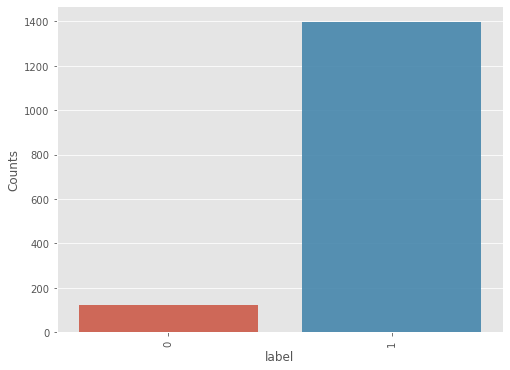

In [9]:
label_counts = df.label.value_counts()
plt.figure(figsize = (8,6))
sns.barplot(label_counts.index, label_counts.values, alpha=0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('label', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.show()

### Correlation between the news length and the classes (fake/real)

In [10]:
# Create a new column "length" the stores the length of the content on each row 
df['length'] = df['content'].map(lambda content: len(content))

df.groupby('label').length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,125.0,441.048000,124.378251,36.0,488.0,492.0,494.0,500.0
1,1397.0,473.110236,73.065309,64.0,489.0,492.0,495.0,502.0


### Visualize length distribution by class

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

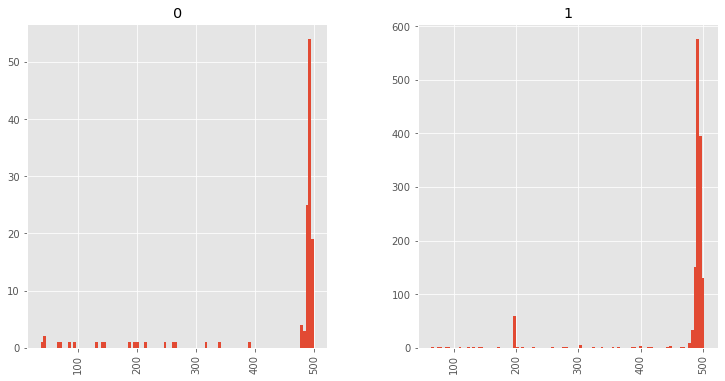

In [11]:
# Use a length threshold to visualize the distribution of length per class

threshold = 1800
News_subset = df[df.length < threshold]
News_subset.hist(column='length', by='label', bins=100, figsize=(12, 6))

## Observation from the EDA
We observe that only **8.21%** news are fake.

Also there are some outliers 

### Text normalization by lemmatization

In [12]:
lemmatizer = WordNetLemmatizer()

df['content_lemmatized'] = df['content'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

### Create a seperate feature set (data matrix X) and target (1D array Y)

In [13]:
X = df["content_lemmatized"] # Data frame containing the target 
y = df['label'] # Data frame containing the features excluding the target

'''
Convert X & y into Arrays
Use the NumPy asarray() method to convert the Pandas data frame object X and y into numpy arrays.
'''
X = np.asarray(X) # Data Matrix containing all features excluding the target
y = np.asarray(y) # 1D target array

print("Data Matrix (X) Shape: ", X.shape)
print("Label array (y) Shape: ", y.shape)

print("\nData Matrix (X) Type: ", X.dtype)
print("Label array (y) Type: ", y.dtype)

# # Read a random News from X
# print("\nA random News:\n")
# print(X[0])

Data Matrix (X) Shape:  (1522,)
Label array (y) Shape:  (1522,)

Data Matrix (X) Type:  object
Label array (y) Type:  int64


### Create train and test dataset

In [14]:
# Partition the dataset into training & test subsets: 80% training & 20% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Experiment 2 Multinomial NB 

In [15]:
text_clf_multinomialNB = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', MultinomialNB()),
    ])

### Model selection: Hyperparameter tuning

In [16]:
%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'clf__alpha': [0.0001, 0.001, 0.1, 1.0, 1.5, 2.0],
}

clf_multinomial_cv = GridSearchCV(text_clf_multinomialNB, param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

clf_multinomial_cv = clf_multinomial_cv.fit(X_train, y_train)


params_optimal_clf_multinomial = clf_multinomial_cv.best_params_

print("\nBest Score: %f" % clf_multinomial_cv.best_score_)
print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, params_optimal_clf_multinomial[param_name]))
    
print("\n")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s



Best Score: 0.977987

Optimal Hyperparameter Values: 
clf__alpha: 0.1
vect__ngram_range: (1, 1)
vect__stop_words: 'english'


CPU times: user 493 ms, sys: 119 ms, total: 612 ms
Wall time: 5.39 s


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.3s finished


### Train the optimal model

In [17]:
multinomialNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 1), binary=False)),
        ('clf', MultinomialNB(alpha=0.1)),
    ])

multinomialNB_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('clf', MultinomialNB(alpha=0.1))])

### Evaluate the model on test data

In [18]:
print("Test Accuracy: ", multinomialNB_clf.score(X_test, y_test))

y_test_predicted = multinomialNB_clf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Fake", "Real"]))

Test Accuracy:  0.9508196721311475

Test Confusion Matrix:
[[ 13  11]
 [  4 277]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.76      0.54      0.63        24
        Real       0.96      0.99      0.97       281

    accuracy                           0.95       305
   macro avg       0.86      0.76      0.80       305
weighted avg       0.95      0.95      0.95       305



### Experiment 3 Multinomial NB (TF-IDF)

In [19]:
text_clf_multinomialNB_tfidf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])

### Model selection: Hyperparameter tuning

In [20]:
%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'clf__alpha': [0.001, 0.1, 1.0, 1.5],
}

clf_multinomial_tfidf_cv = GridSearchCV(text_clf_multinomialNB_tfidf, param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

clf_multinomial_tfidf_cv = clf_multinomial_tfidf_cv.fit(X_train, y_train)



params_optimal_clf_multinomial_tfidf = clf_multinomial_tfidf_cv.best_params_

print("\nBest Score: %f" % clf_multinomial_tfidf_cv.best_score_)
print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, params_optimal_clf_multinomial_tfidf[param_name]))
    
print("\n")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.8s finished



Best Score: 0.968246

Optimal Hyperparameter Values: 
clf__alpha: 0.001
vect__ngram_range: (1, 2)
vect__stop_words: 'english'


CPU times: user 499 ms, sys: 45.7 ms, total: 545 ms
Wall time: 3.17 s


### Train the optimal model

In [21]:
multinomialNB_clf_tfidf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2), binary=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(alpha=0.001)),
    ])

multinomialNB_clf_tfidf.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.001))])

### Evaluate the model on test data

In [22]:
print("Test Accuracy: ", multinomialNB_clf_tfidf.score(X_test, y_test))

y_test_predicted = multinomialNB_clf_tfidf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Fake", "Real"]))

Test Accuracy:  0.9377049180327869

Test Confusion Matrix:
[[  8  16]
 [  3 278]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.73      0.33      0.46        24
        Real       0.95      0.99      0.97       281

    accuracy                           0.94       305
   macro avg       0.84      0.66      0.71       305
weighted avg       0.93      0.94      0.93       305



### Experiment 4: Multivariate Bernoulli NB

In [23]:
text_clf_bernoulliNB = Pipeline([
        ('vect', CountVectorizer(binary=True)),
        ('clf', BernoulliNB()),
    ])


### Model selection: Hyperparameter tuning

In [24]:
%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'clf__alpha': [0.001, 0.1, 1.0, 1.5],
}

clf_bernoulli_cv = GridSearchCV(text_clf_bernoulliNB, param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

clf_bernoulli_cv = clf_bernoulli_cv.fit(X_train, y_train)


params_optimal_clf_bernoulli = clf_bernoulli_cv.best_params_

print("\nBest Score: %f" % clf_bernoulli_cv.best_score_)
print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, params_optimal_clf_bernoulli[param_name]))
    
print("\n")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Best Score: 0.973703

Optimal Hyperparameter Values: 
clf__alpha: 0.1
vect__ngram_range: (1, 1)
vect__stop_words: 'english'


CPU times: user 274 ms, sys: 15.3 ms, total: 289 ms
Wall time: 3.18 s


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.1s finished


### Train the optimal model

In [25]:
bernoulliNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1,1), binary=True)),
        ('clf', BernoulliNB(alpha=0.1)),
    ])

bernoulliNB_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(binary=True, stop_words='english')),
                ('clf', BernoulliNB(alpha=0.1))])

### Evaluate the model on test data

In [26]:
print("Test Accuracy: ", bernoulliNB_clf.score(X_test, y_test))

y_test_predicted = bernoulliNB_clf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Fake", "Real"]))

Test Accuracy:  0.9442622950819672

Test Confusion Matrix:
[[ 11  13]
 [  4 277]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.73      0.46      0.56        24
        Real       0.96      0.99      0.97       281

    accuracy                           0.94       305
   macro avg       0.84      0.72      0.77       305
weighted avg       0.94      0.94      0.94       305



### Experiment 5: KNN using Count vectorization

### Count vectorization for test features. Note that the code below as provides the TF-IDF vectorization which will be directly used to evaluate TF-IDF KNN model later

In [27]:
'''
Depending on the problem scenario, there are various ways of creating the count vectorizer object
'''
#count_vect = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2))
#count_vect = CountVectorizer(lowercase=True, stop_words='english')
#count_vect = CountVectorizer(lowercase=True, stop_words='english', binary=True)
count_vect = CountVectorizer()



# Create a matrix representation of the documents
# Each row represents a single document
# Each column represents the term frequecy for each feature
X_train_vectorized_features = count_vect.fit_transform(X_train).todense()

print("\nSize of Vocabulary: ", len(count_vect.vocabulary_))


print("\nVectorized Training Data Matrix Dimension: ", X_train_vectorized_features.shape)

print("\nType of the Vectorized Training Data Matrix: ")
print(type(X_train_vectorized_features))


# Transform documents to document-term matrix.
# Extract token counts out of raw text documents using the vocabulary fitted with fit 
# or the one provided to the constructor.
X_test_vectorized_features = count_vect.transform(X_test).todense()
print("\nVectorized Test Data Matrix Dimension: ", X_test_vectorized_features.shape)


# TF-IDF Vectorization
tfidf_transformer = TfidfTransformer()
X_train_vectorized_features_tfidf = tfidf_transformer.fit_transform(X_train_vectorized_features).todense()
print(X_train_vectorized_features_tfidf.shape)


X_test_vectorized_features_tfidf = tfidf_transformer.transform(X_test_vectorized_features).todense()
print("\nVectorized Test Data Matrix (TF-IDF) Dimension: ", X_test_vectorized_features_tfidf.shape)


print("\nVectorized Training Data: Row 1, Columns 1 - 20: ", X_train_vectorized_features[0, 0:20])
print("\nVectorized (TF-IDF) Training Data: Row 1, Columns 1 - 20: ", X_train_vectorized_features_tfidf[0, 0:20])



Size of Vocabulary:  7481

Vectorized Training Data Matrix Dimension:  (1217, 7481)

Type of the Vectorized Training Data Matrix: 
<class 'numpy.matrix'>

Vectorized Test Data Matrix Dimension:  (305, 7481)
(1217, 7481)

Vectorized Test Data Matrix (TF-IDF) Dimension:  (305, 7481)

Vectorized Training Data: Row 1, Columns 1 - 20:  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

Vectorized (TF-IDF) Training Data: Row 1, Columns 1 - 20:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Standardized (train & test) data for performng KNN model

In [28]:
# Standardized the data 
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train_vectorized_features)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train_vectorized_features)
X_test = scaler.transform(X_test_vectorized_features)

### Model selection: Hyperparameter tuning

In [29]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': [ 5, 7, 9, 11], 'p': [2, 3, 4, 100], 'weights': ["uniform", "distance"]}


knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1_micro', cv=5, verbose=1, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  5.1min finished


Best Score: 0.920293
Optimal Hyperparameter Values:  {'n_neighbors': 5, 'p': 100, 'weights': 'distance'}


Wall time: 5min 6s


### Train the optimal model

In [30]:
%%time

knn = KNeighborsClassifier(**params_optimal_knn)

knn.fit(X_train, y_train)

y_train_predicted = knn.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn)


Training Accuracy:  0.9991783073130649
Wall time: 1min 30s


### Evaluate the model on test data

In [31]:
%%time

# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))


# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))

# Classification report
print(classification_report(y_test, y_test_predicted, target_names = ["Fake", "Real"]))

print("\n")


Test Accuracy:  0.9311475409836065

No. of correct predictions (Test): 284/305

Confusion Matrix (Test Data):
 [[  5  19]
 [  2 279]]
              precision    recall  f1-score   support

        Fake       0.71      0.21      0.32        24
        Real       0.94      0.99      0.96       281

    accuracy                           0.93       305
   macro avg       0.83      0.60      0.64       305
weighted avg       0.92      0.93      0.91       305



Wall time: 44.8 s


### Experiment 5: KNN using TF-IDF vectorization

### TF-IDF vectorization for test features (reweight features), it has been done before as mentioned

### Standardized (train & test) data for performng KNN model

In [32]:
# Standardized the data 
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train_vectorized_features_tfidf)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train_vectorized_features_tfidf)
X_test = scaler.transform(X_test_vectorized_features_tfidf)

### Model selection: Hyperparameter tuning

In [33]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': [2, 3, 4, 5], 'p': [1, 2, 3, 100], 'weights': ["uniform", "distance"]}


knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1_micro', cv=5, verbose=1, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  4.2min finished


Best Score: 0.921116
Optimal Hyperparameter Values:  {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}


Wall time: 4min 13s


### Train the optimal model

In [34]:
%%time

knn = KNeighborsClassifier(**params_optimal_knn)

knn.fit(X_train, y_train)

y_train_predicted = knn.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn)


Training Accuracy:  0.9991783073130649
Wall time: 17.9 s


### Evaluate the model on test data

In [35]:
%%time

# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))


# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))

# Classification report 

print(classification_report(y_test, y_test_predicted, target_names = ["Fake", "Real"]))

print("\n")


Test Accuracy:  0.9377049180327869

No. of correct predictions (Test): 286/305

Confusion Matrix (Test Data):
 [[  5  19]
 [  0 281]]
              precision    recall  f1-score   support

        Fake       1.00      0.21      0.34        24
        Real       0.94      1.00      0.97       281

    accuracy                           0.94       305
   macro avg       0.97      0.60      0.66       305
weighted avg       0.94      0.94      0.92       305



Wall time: 8.26 s


### Q-2) Which classifier model performed the best (high precision & recall for thefake news class)? Explain why.

According to the results from Multinominal NB, Multinominal NB (TF-IDF Features), Multivariate Bernoulli NB, K-NN (count vectorization) and KNN (TF-IDF Features), we found that the **Multinomial NB model** has the **best** precision & recall for the fake news class, and it has the best test accuracy as well. 

Multinominal NB (TF-IDF Features) has poorer performance might be caused by wrongly reduced weight on the "key" words appearing in all fake news samples. In this example, the frequency of words appearing in the documents might be the key to acquire better model performance. While Multivariate Bernoulli NB that accounts for categorical feature (binary valued) only consider the “word occurs in the document” and “word does not occur in the document”, but not the frequency of the word. So, Bernoulli has lower accuracy compared to Multinomial NB that accounted the frequency.

### Q-3) Why is the performance (precision & recall) of the true/real class higher thanthe fake class? Explain.

According to the bar chart of class distribution, the fake news (N=125) has much lesser samples than real news (N=1397). That is the main reason why the real class has higher precision and recall than the fake class because it has much more data to better train the model.

### Q-4) Did K-NN outperform the Naïve Bayes models? Would you use K-NN for this type of text classification problem? Why or why not? Justify?

Both KNN using count or TF-IDF vectorizations did not outperform the NB models. We would not recommend using KNN models for this text classification problem because it takes longer time to perform and ends up with lower test accuracy then NB models. 